In [1]:
import os
import pandas as pd
import numpy as np
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, transforms
import matplotlib.pyplot as plt

In [2]:
plt.rcdefaults()

In [3]:
# Plotting function

def plot_spectrogram(spec, title, time, frequency, start_longest_mode=None, end_longest_mode=None):
    fig, ax = plt.subplots()
    ax.imshow(spec.T, extent=(time[0], time[-1], frequency[0], frequency[-1]), aspect='auto', cmap='jet',
              origin='lower')
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(frequency[0], frequency[-1])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    fig.set_dpi(150)
    plt.title(title)

    # Plot vertical lines if start and end times are provided
    if start_longest_mode is not None and end_longest_mode is not None:
        ax.axvline(x=start_longest_mode, color='blue', linestyle='--', label='Start of Longest Mode')
        ax.axvline(x=end_longest_mode, color='darkblue', linestyle='--', label='End of Longest Mode')
        plt.legend(loc='upper left')

    plt.show()

In [4]:
DATA_PATH = "data/dataset_pickle"
FILE_EXT = "pickle"

def load_shot(shotno, data_path, file_ext):
    file_path = os.path.join(data_path, f"{shotno}.{file_ext}")
    return pd.read_pickle(file_path)

class SpectrogramDataset(Dataset):
    def __init__(self, data_path, file_ext, window_size, transform=None, overlap_factor = 0):
        # data loading
        self.data_path = data_path
        self.file_ext = file_ext
        self.window_size = window_size
        self.transform = transform
        self.overlap_factor = overlap_factor # Parameter determining how much overlap there is when doing window sliding between 0 and 1

        # Obtain all shot numbers
        self.all_shots = [int(os.path.basename(x.split(f".{file_ext}")[0]))
                          for x in glob.glob(os.path.join(data_path, f"*.{file_ext}"))]

    def __len__(self):
        return len(self.all_shots)
    
    """
    The get method describes how a single experiment is handeled, whereas the dataloader will make sure
    that the batching is done correctly!
    
    """

    def __getitem__(self, idx):
        shotno = self.all_shots[idx]

        # Load data for the experiment
        data_shot = load_shot(shotno, self.data_path, self.file_ext)

        # Extract inputs
        inputs = data_shot["x"]["spectrogram"]
        spec_even = inputs["EvenN"]
        spec_odd = inputs["OddN"]
        f = inputs["frequency"]
        t = inputs["time"]

        # Calculate the number of windows based on window size
        num_windows = int(np.floor((spec_even.shape[0] - self.window_size) / (self.window_size * (1 - self.overlap_factor)))) 
        print(len(t), num_windows)

        # Extract windows along with their start and end indices
        windows = []
        for i in range(num_windows):
            start_idx = int(i * self.window_size * (1 - self.overlap_factor))
            end_idx = start_idx + self.window_size

            window_even = spec_even[:, start_idx:end_idx]
            window_odd = spec_odd[:, start_idx:end_idx]

            if self.transform:
                window_even = self.transform(window_even)
                window_odd = self.transform(window_odd)

            windows.append({
                'window_even': window_even,
                'window_odd': window_odd,
                'frequency': f,
                'time': t[start_idx:end_idx],
                'start_idx': start_idx,
                'end_idx': end_idx,
                'shotno': shotno
            })

        return windows
    
    

# Example usage:
# Define hyperparameters
DATA_PATH = "data/dataset_pickle"
FILE_EXT = "pickle"
window_size = 64  # Length of the window
batch_size = 32 # Number of experiments (shots) to include in each batch
overlap_factor = 0.5 # Factor that determines the overlap when selecting sliding windows

# Create dataset and dataloader
#transform = transforms.Compose([
    # Add any additional transformations you need
#])

dataset = SpectrogramDataset(data_path = DATA_PATH, file_ext = FILE_EXT, window_size = window_size, transform=None, overlap_factor = overlap_factor)
dataloader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
class SpectrogramDataset(Dataset):
    def __init__(self, data_path, file_ext, window_size, transform=None, overlap_factor=0):
        self.data_path = data_path
        self.file_ext = file_ext
        self.window_size = window_size
        self.transform = transform
        self.overlap_factor = overlap_factor

        self.all_shots = [int(os.path.basename(x.split(f".{file_ext}")[0]))
                          for x in glob.glob(os.path.join(data_path, f"*.{file_ext}"))]

    def __len__(self):
        return sum(len(self.get_windows(shotno)) for shotno in self.all_shots)

    def get_windows(self, shotno):
        data_shot = load_shot(shotno, self.data_path, self.file_ext)

        inputs = data_shot["x"]["spectrogram"]
        spec_even = inputs["EvenN"]
        spec_odd = inputs["OddN"]
        f = inputs["frequency"]
        t = inputs["time"]

        num_windows = int(np.floor(spec_even.shape[1] / (self.window_size * (1 - self.overlap_factor))))

        windows = []
        for i in range(num_windows):
            start_idx = int(i * self.window_size * (1 - self.overlap_factor))
            end_idx = start_idx + self.window_size

            window_even = spec_even[:, start_idx:end_idx]
            window_odd = spec_odd[:, start_idx:end_idx]

            if self.transform:
                window_even = self.transform(window_even)
                window_odd = self.transform(window_odd)

            windows.append({
                'window_even': window_even,
                'window_odd': window_odd,
                'frequency': f,
                'time': t[start_idx:end_idx],
                'start_idx': start_idx,
                'end_idx': end_idx,
                'shotno': shotno
            })

        return windows

    def __getitem__(self, idx):
        current_idx = 0
        for shotno in self.all_shots:
            windows = self.get_windows(shotno)
            if current_idx + len(windows) > idx:
                return windows[idx - current_idx]
            current_idx += len(windows)

# Example usage
window_size = 64
overlap_factor = 0.5
batch_size = 1  # Use a batch size of 1

dataset = SpectrogramDataset(DATA_PATH, FILE_EXT, window_size, overlap_factor=overlap_factor)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Iterating through the dataloader
for batch_idx, batch in enumerate(dataloader):
    for sample in batch:
        print(sample['window_even'].shape)
        print(sample['start_idx'], sample['end_idx'])
        print(sample['time'])
        print(sample['shotno'])


In [10]:
for batch_idx, batch in enumerate(dataloader):
    for sample in batch:
        print(sample['window_even'].shape)
        print(sample['start_idx'], sample['end_idx'])
        print(sample['time'])
        print(sample['shotno'])

2248 68
2327 70
1911 57
3573 109
1903 57
2690 82
1397 41
2176 66
3434 105
2258 68
2055 62
2346 71
3202 98
1911 57
2030 61
2100 63
1922 58
2280 69
2014 60
2247 68
2913 89
2164 65
2071 62
3231 98
2569 78
4293 132
2055 62
2291 69
4293 132
4293 132
3053 93
3004 91


RuntimeError: each element in list of batch should be of equal size

## Number of windows per batch

In [5]:
# dataset = Way of representing the dataset so it can be loaded with the dataloader

# dataloader = Used to load batches of data from our dataset

In [6]:
first_data = dataset[93][54] # First item of the first batch of 32 windows (which all correspond to a SINGLE shotno)
# First number is the shotno, the second one is which window we are accessing for that shotno.

for key, item in first_data.items():
    if isinstance(item, (list, np.ndarray, torch.Tensor)):
        if isinstance(item, (np.ndarray, torch.Tensor)):
            print(key, item.shape)
        else:
            print(key, len(item))
    elif isinstance(item, int):
        print(key, item)

2280 69
window_even (2280, 64)
window_odd (2280, 64)
frequency (2049,)
time (64,)
start_idx 1728
end_idx 1792
shotno 73023


4293 132
Experiment number: 73020, and window number: 2


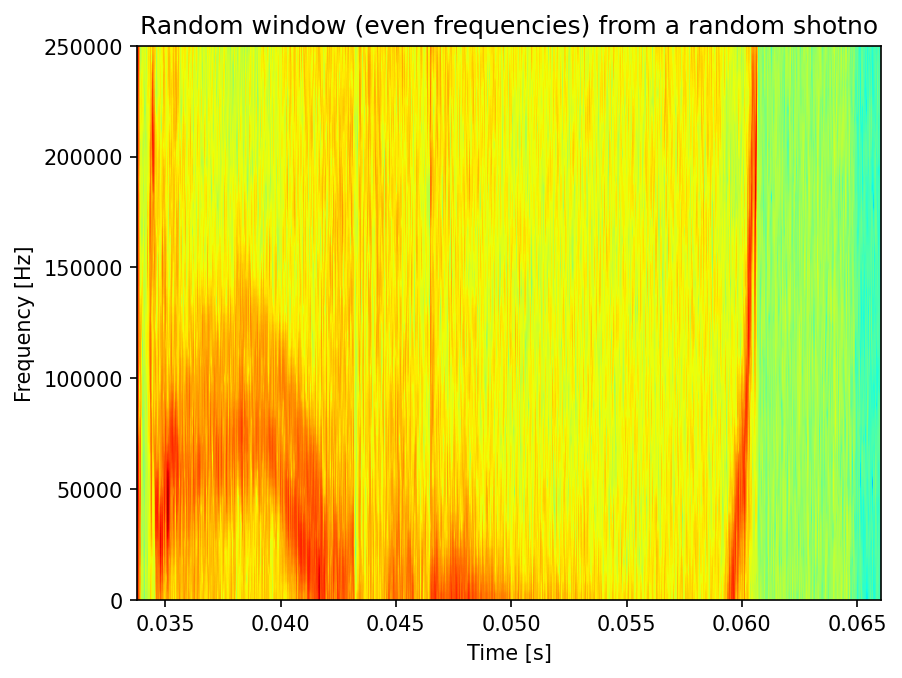

In [7]:
idx_shotno = np.random.randint(1,94) # Choose a random experiment
idx_windowno = np.random.randint(1,batch_size)
# Plot a random window (even frequencies) from a random shotno
random_sample = dataset[idx_shotno][idx_windowno]
print(f"Experiment number: {random_sample['shotno']}, and window number: {idx_windowno}")

plot_spectrogram(random_sample["window_odd"], title = "Random window (even frequencies) from a random shotno",\
                time = random_sample["time"], frequency = random_sample["frequency"])

### Let's verify that this is correct using the real data

In [8]:
data_shot = load_shot(random_sample['shotno'], DATA_PATH, FILE_EXT)

# Extracting inputs
inputs = data_shot["x"]["spectrogram"]
spec_even = inputs["EvenN"]
spec_odd = inputs["OddN"]
f = inputs["frequency"]
t = inputs["time"]

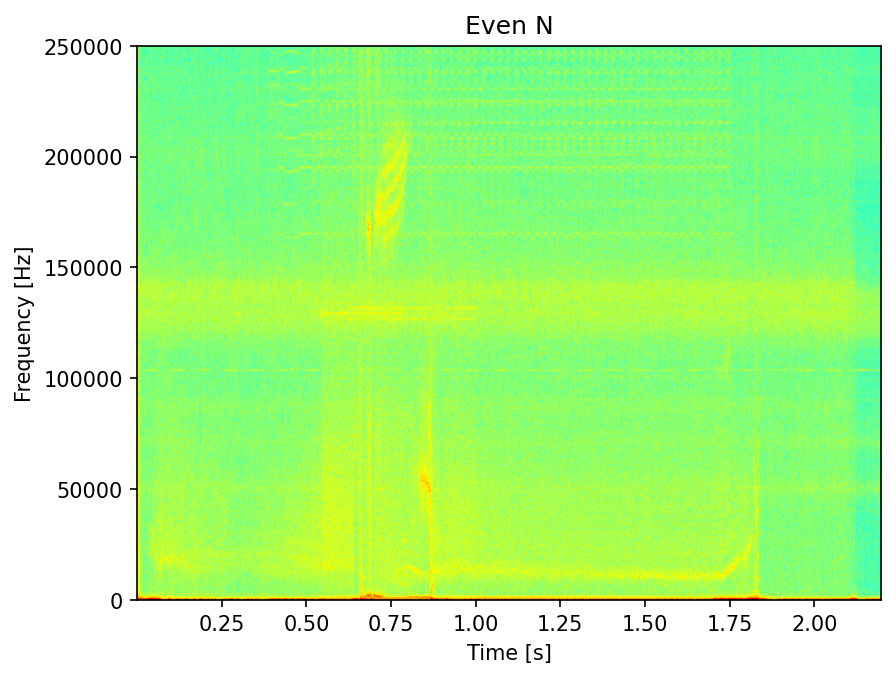

In [9]:
plot_spectrogram(spec_even, "Even N", t, f)